In [1]:
import sys
import os

# Go up to project root (from inside training/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import torch
import torch.nn as nn
from core.models.base_transformer_model import SimpleTransformerEncoder
import gc
import random
from core.utils import create_transformer_dataset

In [3]:
def initial_cleanup():
    # Memory cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()
    
    # Set random seeds
    random.seed(69)
    np.random.seed(69)
    torch.manual_seed(69)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(69)
        torch.cuda.manual_seed_all(69)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print("Clean slate initialized!")

# Call this at the top of your notebook
initial_cleanup()

Clean slate initialized!


In [4]:
# Training
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
X, y, attention_masks, final_sequence_lengths = create_transformer_dataset(data_dir="../../data/keypoints", percentile_cutoff=95.0)

Using max_frames = 200 (95.0th percentile)
Sequence length stats - Min: 0, Max: 404
Filtering out sample with length 236
Filtering out sample with length 236
Filtering out sample with length 267
Filtering out sample with length 267
Filtering out sample with length 237
Filtering out sample with length 237
Filtering out sample with length 248
Filtering out sample with length 248
Filtering out sample with length 207
Filtering out sample with length 207
Filtering out sample with length 219
Filtering out sample with length 219
Filtering out sample with length 280
Filtering out sample with length 280
Filtering out sample with length 249
Filtering out sample with length 249
Filtering out sample with length 247
Filtering out sample with length 247
Filtering out sample with length 210
Filtering out sample with length 210
Filtering out sample with length 215
Filtering out sample with length 215
Filtering out sample with length 283
Filtering out sample with length 283
Filtering out sample with le

In [6]:
X = X[:, :, :, :3]  # drop visibility

# Convert to PyTorch tensors
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).long()


X_temp, X_test, y_temp, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=69, stratify=y)

val_ratio = 0.1 / 0.9  # ≈ 0.1111 of remaining
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=69, stratify=y_temp)

# Create dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
parameters = dict(
    num_joints=33,
    num_frames=200 ,
    d_model=64,
    dim_feedforward=512,
    nhead=4,
    num_layers = 2,
    num_classes=3,
    dropout=0.3,
)

epochs = 50 # target number of epochs

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleTransformerEncoder(**parameters).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

In [9]:

train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    # ---------- EARLY STOPPING ----------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Epoch 1/50 | Train Loss: 1.0794, Acc: 0.4070 | Val Loss: 1.0356, Acc: 0.4811
Epoch 2/50 | Train Loss: 1.0071, Acc: 0.5521 | Val Loss: 0.8910, Acc: 0.5991
Epoch 3/50 | Train Loss: 0.8114, Acc: 0.7441 | Val Loss: 0.6438, Acc: 0.8443
Epoch 4/50 | Train Loss: 0.6585, Acc: 0.8472 | Val Loss: 0.5457, Acc: 0.8915
Epoch 5/50 | Train Loss: 0.6002, Acc: 0.8602 | Val Loss: 0.5478, Acc: 0.8868
Epoch 6/50 | Train Loss: 0.5443, Acc: 0.8809 | Val Loss: 0.4824, Acc: 0.8962
Epoch 7/50 | Train Loss: 0.5065, Acc: 0.8904 | Val Loss: 0.4670, Acc: 0.9104
Epoch 8/50 | Train Loss: 0.4803, Acc: 0.8999 | Val Loss: 0.4544, Acc: 0.9104
Epoch 9/50 | Train Loss: 0.4685, Acc: 0.9070 | Val Loss: 0.4431, Acc: 0.9057
Epoch 10/50 | Train Loss: 0.4574, Acc: 0.9147 | Val Loss: 0.4350, Acc: 0.9245
Epoch 11/50 | Train Loss: 0.4515, Acc: 0.9111 | Val Loss: 0.4317, Acc: 0.9245
Epoch 12/50 | Train Loss: 0.4401, Acc: 0.9188 | Val Loss: 0.4397, Acc: 0.9104
Epoch 13/50 | Train Loss: 0.4394, Acc: 0.9182 | Val Loss: 0.4326, Acc: 0.

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Switch to eval mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # If your model uses the mask in forward()
        outputs = model(X_batch)

        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['squats', 'deadlifts', 'shoulder_press'])
print(report)

                precision    recall  f1-score   support

        squats       0.92      0.91      0.91        86
     deadlifts       0.86      0.93      0.89        55
shoulder_press       0.96      0.92      0.94        71

      accuracy                           0.92       212
     macro avg       0.91      0.92      0.91       212
  weighted avg       0.92      0.92      0.92       212



[[78  5  3]
 [ 4 51  0]
 [ 3  3 65]]


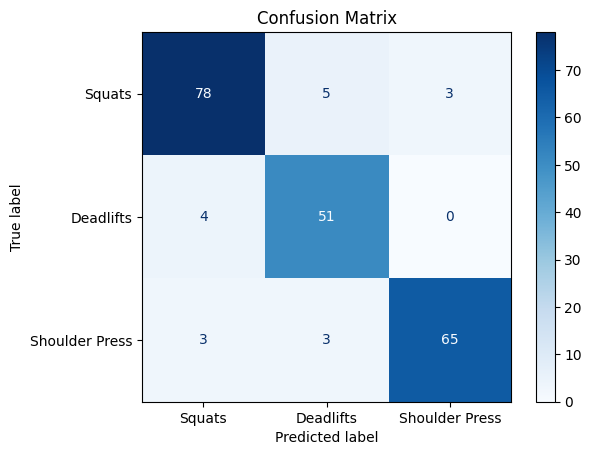

In [ ]:
matrix = confusion_matrix(all_labels, all_preds)
print(matrix)

class_names = ['Squats', 'Deadlifts', 'Shoulder Press']

ConfusionMatrixDisplay.from_predictions(all_labels, all_preds,
                                        display_labels=class_names,
                                        cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

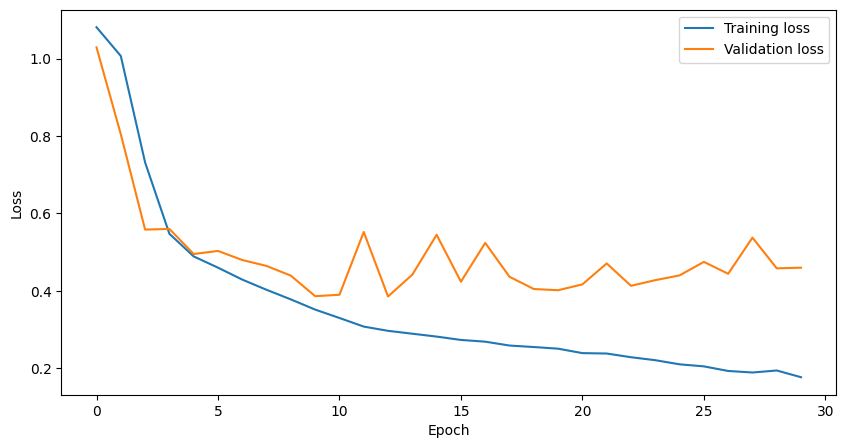

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

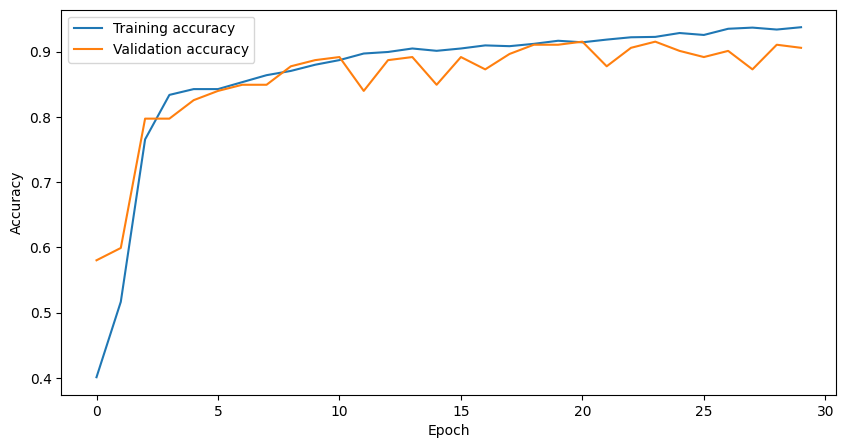

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training accuracy')
plt.plot(val_acc_history, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from core.utils import generate_model_filename

In [ ]:
model_name = "base_hierarchical_transformer"
filename = generate_model_filename(base_name=model_name, params=parameters)
# Save
save_path = os.path.join("../../models", model_name, filename)
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
